## CPC353: Natural Language Processing

### Title: Speaker Change Detection Using F0 and MFCC Features with the IEMOCAP Dataset

#### Group Information

- Member 1: Chau Hong Feng (164823)
- Member 2: Ooi Jin Shen (163919)

### *1. Prepare the dataset*

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import parselmouth
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

#### Path to folders

In [2]:
# Path to the folders
audio_folder = 'C:/Users/waipe/OneDrive/Desktop/Y3/Semester I/CPC353 Natural Language Processing/Assignment 2/IEMOCAP/IEMOCAP/'
rttm_folder = "C:/Users/waipe/OneDrive/Desktop/Y3/Semester I/CPC353 Natural Language Processing/Assignment 2/IEMOCAP/IEMOCAP/reference"

#### Global Variables

In [3]:
# Global Variables
SAMPLE_RATE = 16000
N_MFCC = 13
FRAME_LENGTH = 1.0  
FRAME_OVERLAP = 0.5  

### 2. Feature Extraction

In [4]:
# Retrieve all .wav files from the given audio folder
def get_wav_files(audio_folder):
    wav_files = []
    for session in range(1, 7):  # Assuming 6 sessions
        wav_folder = os.path.join(audio_folder, f'Session{session}', 'dialog', 'wav')
        if os.path.isdir(wav_folder):
            for wav_file in os.listdir(wav_folder):
                if wav_file.endswith('.wav'):
                    wav_path = os.path.join(wav_folder, wav_file)
                    if os.path.isfile(wav_path):  # Ensure it's a valid file
                        wav_files.append(wav_path)
    return wav_files

In [5]:
# Extract MFCC features from a single .wav file
def extract_mfcc_features(wav_path, n_mfcc=N_MFCC, frame_length=FRAME_LENGTH, frame_overlap=FRAME_OVERLAP, sample_rate=SAMPLE_RATE):
    try:
        y, sr = librosa.load(wav_path, sr=sample_rate)
        
        frame_length_samples = int(frame_length * sr)
        
        hop_length_samples = int(frame_overlap * sr)
        
        mfcc = librosa.feature.mfcc(
            y=y, sr=sr, n_mfcc=n_mfcc,
            n_fft=frame_length_samples,
            hop_length=hop_length_samples
        )
        return mfcc.T  # Transpose to have time steps as rows
    except Exception as e:
        print(f"Error processing {wav_path}: {e}")
        return None

In [6]:
# Extract f0 features from a single .wav file
def extract_f0(wav_path, pitch_floor=75, pitch_ceiling=600, interpolation=True, smoothing=True):
    try:
        # Load the audio file using parselmouth
        sound = parselmouth.Sound(wav_path)

        # Extract pitch using the specified pitch range
        pitch = sound.to_pitch(pitch_floor=pitch_floor, pitch_ceiling=pitch_ceiling)
        f0 = pitch.selected_array['frequency']

        # Replace 0 with NaN to indicate unvoiced regions
        f0[f0 == 0] = np.nan

        # Interpolate missing values
        if interpolation:
            valid_mask = ~np.isnan(f0)
            if np.any(valid_mask):  # Check if there are valid F0 values
                interp_func = interp1d(
                    np.where(valid_mask)[0],  # Indices of valid F0 values
                    f0[valid_mask],          # Valid F0 values
                    kind='linear',           # Linear interpolation
                    fill_value="extrapolate" # Extrapolate for edge cases
                )
                f0 = interp_func(np.arange(len(f0)))  # Interpolate all values
            else:
                f0 = np.zeros_like(f0)  # If no valid F0, return zeros

        # Smooth the F0 contour
        if smoothing and len(f0) > 0:
            f0 = savgol_filter(f0, window_length=5, polyorder=2)

        return f0

    except Exception as e:
        print(f"Error processing {wav_path}: {e}")
        return None

In [7]:
# Plot the features
def plot_features(wav_path, mfcc, f0, sample_rate=SAMPLE_RATE, frame_overlap=FRAME_OVERLAP):
    plt.figure(figsize=(10, 6))

    # Load the audio file to get the duration
    y, sr = librosa.load(wav_path, sr=sample_rate)
    duration = librosa.get_duration(y=y, sr=sr)

    # Plot MFCC
    plt.subplot(2, 1, 1)
    librosa.display.specshow(mfcc.T, x_axis='time', sr=sample_rate, hop_length=int(frame_overlap * sample_rate))
    plt.colorbar(label='MFCC')
    plt.title(f'MFCCs for {os.path.basename(wav_path)}')

    # Plot F0 (Fundamental Frequency)
    plt.subplot(2, 1, 2)
    # Adjust the time vector to reflect the full duration of the audio
    times = np.linspace(0, duration, len(f0))
    plt.plot(times, f0, label='F0 (Pitch)', color='r')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Fundamental Frequency (F0) for {os.path.basename(wav_path)}')
    plt.legend()

    plt.tight_layout()
    plt.show()

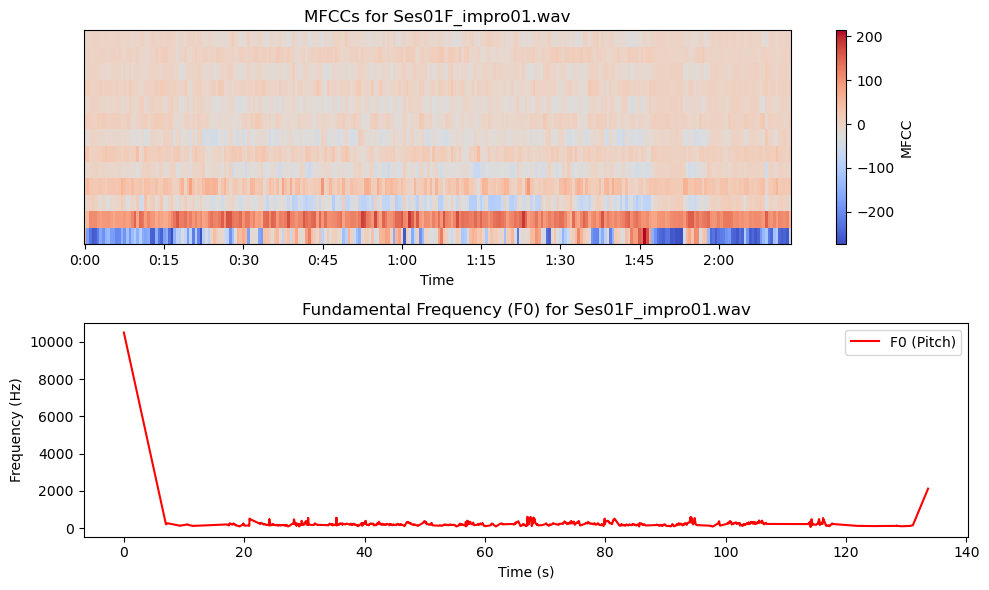

In [8]:
# Extracted features for a sample audio file 
wav_files = get_wav_files(audio_folder)

# Select the first .wav file
sample_audio = wav_files[0]

# Extract MFCC and F0 features
mfcc = extract_mfcc_features(sample_audio)
f0 = extract_f0(sample_audio)

# Plot the features
if mfcc is not None and f0 is not None:
    plot_features(sample_audio, mfcc, f0)
else:
    print("Failed to extract features for the sample audio.")

In [9]:
# Print the first 10 values of MFCC and F0
if mfcc is not None and f0 is not None:
    print("First 10 values of F0 (Fundamental Frequency):")
    print(f0[:10])  # Print the first 10 values of f0
    print("\nFirst 10 values of MFCC:")
    print(mfcc[:, :10])  # Print the first 10 MFCC values (across all coefficients)

else:
    print("Failed to extract features for the sample audio.")

First 10 values of F0 (Fundamental Frequency):
[10498.78085815 10484.01248249 10469.24410683 10454.47573116
 10439.7073555  10424.93897983 10410.17060417 10395.4022285
 10380.63385284 10365.86547717]

First 10 values of MFCC:
[[  59.56286      26.013386    -43.095695   ...   12.903914
   -24.653044     17.92548   ]
 [-177.9902       49.310745      2.5447297  ...   14.282096
    -4.466742     15.379907  ]
 [-229.91586     109.71345       9.575693   ...    9.911701
     2.5147347     4.1880684 ]
 ...
 [-246.01071     104.19162       0.35846528 ...   -3.3588262
     0.85142076    6.986275  ]
 [-259.33102     113.40605       8.445125   ...   -0.84327507
     4.954671      4.8629265 ]
 [ -57.11762      48.872932    -21.422384   ...    9.441285
    -5.273718      7.005814  ]]


### 3. Data Preprocessing

In [10]:
# Parse the RTTM file and extract speaker segments.
def parse_rttm(rttm_file):
    segments = []
    with open(rttm_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            start_time = float(parts[3])
            duration = float(parts[4])
            speaker_id = parts[7]
            end_time = start_time + duration
            segments.append((start_time, end_time, speaker_id))
    return segments

In [11]:
# Detect speaker changes within a given timeframe
def detect_speaker_changes_in_timeframe(segments, timeframe_duration):
    labels = []
    if not segments:
        return labels

    segments.sort(key=lambda x: x[0])
    current_time = 0.0
    max_time = segments[-1][1]
    speaker_change_times = []
    prev_speaker = None

    for segment in segments:
        start_time, _, speaker_id = segment
        if prev_speaker is not None and speaker_id != prev_speaker:
            speaker_change_times.append(start_time)
        prev_speaker = speaker_id

    while current_time < max_time:
        timeframe_end = current_time + timeframe_duration
        timeframe_label = 0
        for change_time in speaker_change_times:
            if current_time <= change_time < timeframe_end:
                timeframe_label = 1
                break
        labels.append(timeframe_label)
        current_time = timeframe_end

    return labels

In [12]:
# Process the RTTM file to detect speaker changes within timeframes.
def process_audio_file(rttm_file, timeframe_duration):
    segments = parse_rttm(rttm_file)
    labels = detect_speaker_changes_in_timeframe(segments, timeframe_duration)
    return labels

In [13]:
#  Extract features and labels, then save them to a CSV file
def save_features_and_labels_to_csv(wav_files, rttm_folder, output_csv, timeframe_duration):
    data = []

    # Process RTTM files to get labels
    results = {}
    for rttm_filename in tqdm(os.listdir(rttm_folder), desc="Processing RTTM files"):
        if rttm_filename.endswith(".rttm"):
            rttm_file = os.path.join(rttm_folder, rttm_filename)
            file_id = os.path.splitext(rttm_filename)[0]
            binary_labels = process_audio_file(rttm_file, timeframe_duration)
            results[file_id] = binary_labels

    # Process WAV files to extract MFCC and F0 features
    for wav_path in tqdm(wav_files, desc="Processing WAV files"):
        file_id = os.path.splitext(os.path.basename(wav_path))[0]
        mfcc = extract_mfcc_features(wav_path)
        f0 = extract_f0(wav_path)
        labels = results.get(file_id, [])

        if mfcc is not None and f0 is not None and labels:
            # Ensure all arrays have the same length
            min_length = min(len(mfcc), len(f0), len(labels))
            for i in range(min_length):
                row = {
                    'file_id': file_id,
                    'timeframe': i * timeframe_duration,
                    **{f'mfcc_{j}': mfcc[i][j] for j in range(mfcc.shape[1])},
                    'f0': f0[i],
                    'label': labels[i]
                }
                data.append(row)

    # Convert to DataFrame and save to CSV
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"Features and labels saved to {output_csv}")

In [14]:
 # Initialize empty lists to hold file paths for training, validation, and test sets
def split_wav_files(audio_folder):
    train_files = []
    validation_files = []
    test_files = []

    for session in range(1, 7):  # Assuming 6 sessions
        session_folder = os.path.join(audio_folder, f'Session{session}')
        wav_folder = os.path.join(session_folder, 'dialog', 'wav')

        if os.path.isdir(wav_folder):
            wav_files = [
                os.path.join(wav_folder, file)
                for file in os.listdir(wav_folder)
                if file.endswith('.wav')
            ]

            if session <= 3:  # Training set: Session 1-3
                train_files.extend(wav_files)
            elif session == 4:  # Validation set: Session 4
                validation_files.extend(wav_files)
            elif session == 5:  # Test set: Session 5
                test_files.extend(wav_files)

    print(f"Number of training files: {len(train_files)}")
    print(f"Number of validation files: {len(validation_files)}")
    print(f"Number of test files: {len(test_files)}")

    return train_files, validation_files, test_files

In [15]:
# Split .wav files into train, validation, and test sets
train_files, validation_files, test_files = split_wav_files(audio_folder)

# Save features and labels for train, validation, and test sets
save_features_and_labels_to_csv(train_files, rttm_folder, 'train.csv', FRAME_LENGTH)
save_features_and_labels_to_csv(validation_files, rttm_folder, 'validation.csv', FRAME_LENGTH)
save_features_and_labels_to_csv(test_files, rttm_folder, 'test.csv', FRAME_LENGTH)

Number of training files: 90
Number of validation files: 30
Number of test files: 31


Processing WAV files: 100%|██████████| 90/90 [01:27<00:00,  1.03it/s]


Features and labels saved to train.csv


Processing WAV files: 100%|██████████| 30/30 [00:29<00:00,  1.02it/s]


Features and labels saved to validation.csv


Processing WAV files: 100%|██████████| 31/31 [00:30<00:00,  1.02it/s]


Features and labels saved to test.csv


In [16]:
# Load datasets
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')

In [17]:
# Print the first 10 rows of each dataset
print("First 10 rows of the training dataset:")
print(train_df.head(10))  # First 10 rows of the training dataset

print("\nFirst 10 rows of the validation dataset:")
print(val_df.head(10))  # First 10 rows of the validation dataset

print("\nFirst 10 rows of the test dataset:")
print(test_df.head(10))  # First 10 rows of the test dataset

First 10 rows of the training dataset:
          file_id  timeframe     mfcc_0      mfcc_1     mfcc_2     mfcc_3  \
0  Ses01F_impro01        0.0   59.56286   26.013386 -43.095695  21.462040   
1  Ses01F_impro01        1.0 -177.99020   49.310745   2.544730  47.077015   
2  Ses01F_impro01        2.0 -229.91586  109.713450   9.575693  28.942406   
3  Ses01F_impro01        3.0 -257.46188  106.318290  12.691544  23.849974   
4  Ses01F_impro01        4.0 -252.81538  106.335754   7.049790  20.541150   
5  Ses01F_impro01        5.0 -218.02704   93.083580  -3.597971  24.860030   
6  Ses01F_impro01        6.0 -164.47224   85.945220 -22.169674  27.261263   
7  Ses01F_impro01        7.0 -191.98384   93.007130  -0.148362  23.276712   
8  Ses01F_impro01        8.0 -147.48433   90.926190 -18.363280  13.910666   
9  Ses01F_impro01        9.0 -134.44754   95.519150 -34.243557  25.239717   

      mfcc_4     mfcc_5     mfcc_6     mfcc_7     mfcc_8     mfcc_9  \
0 -20.277908  29.223480 -32.634865  12.903

In [18]:
# Combine training and validation datasets for experimentation
train_val_df = pd.concat([train_df, val_df])

In [19]:
# Feature columns (exclude file_id, timeframe, and label)
feature_columns = [col for col in train_df.columns if col not in ['file_id', 'timeframe', 'label']]

In [20]:
# Prepare data
X_train = train_val_df[feature_columns]
y_train = train_val_df['label']
X_test = test_df[feature_columns]
y_test = test_df['label']

In [21]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Model Development

In [22]:
# Define the neural network model
def build_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  
    ])
    return model

In [23]:
# Build the model
model = build_model(X_train_scaled.shape[1])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    verbose=1
)

# Evaluate the model on the test set
y_pred = model.predict(X_test_scaled)

# Set a custom threshold 
threshold = 0.15
y_pred_binary = (y_pred > threshold).astype(int)

C:\Users\waipe\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6257 - loss: 0.7165 - val_accuracy: 0.8023 - val_loss: 0.4976
Epoch 2/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8052 - loss: 0.5124 - val_accuracy: 0.8023 - val_loss: 0.4983
Epoch 3/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8124 - loss: 0.4944 - val_accuracy: 0.8023 - val_loss: 0.4956
Epoch 4/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8134 - loss: 0.4891 - val_accuracy: 0.8023 - val_loss: 0.4952
Epoch 5/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8134 - loss: 0.4861 - val_accuracy: 0.8023 - val_loss: 0.4951
Epoch 6/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8189 - loss: 0.4765 - val_accuracy: 0.8023 - val_loss: 0.4946
Epoch 7/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8150 - loss: 0.4814 - val_accuracy: 0.8023 - val_loss: 0.4945
Epoch 8/30
405/405 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8117 - loss: 0.4850 - val_accuracy: 0.

In [24]:
# Performance metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

f1 = f1_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.19      0.30      6905
           1       0.22      0.85      0.35      1838

    accuracy                           0.33      8743
   macro avg       0.52      0.52      0.33      8743
weighted avg       0.70      0.33      0.31      8743

F1-Score: 0.3462
Precision: 0.2174
Recall: 0.8493


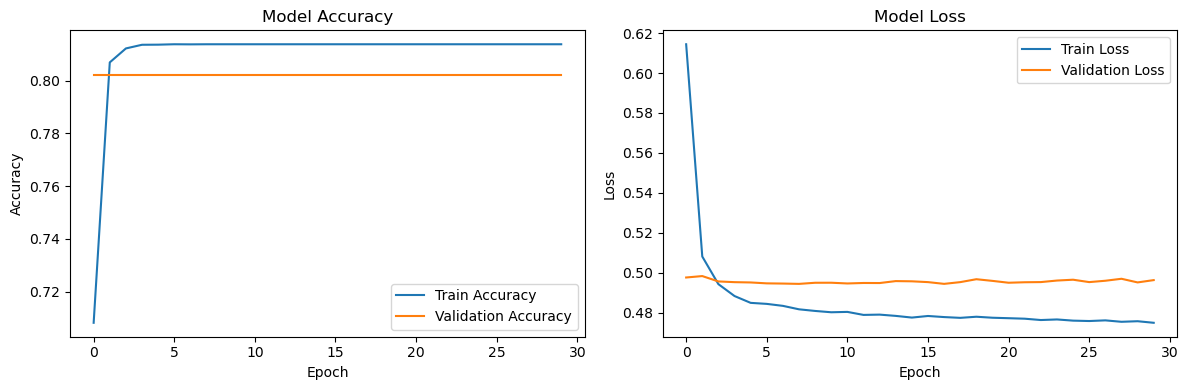

In [25]:
# Plotting the metrics for visualization
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### 5. Results and Discussion

In [45]:
def create_time_lagged_features(df, time_lags=[1, 2, 3]):
    feature_columns = [col for col in df.columns if col not in ['file_id', 'timeframe', 'label']]
    
    lagged_dfs = [df[feature_columns]]
    
    for lag in time_lags:
        lagged_df = df[feature_columns].shift(lag).fillna(0)
        lagged_df.columns = [f'{col}_lag_{lag}' for col in lagged_df.columns]
        lagged_dfs.append(lagged_df)
    
    result_df = pd.concat(lagged_dfs, axis=1)
    result_df['label'] = df['label']
    
    return result_df

def build_model(input_shape, layers=[128, 64, 32], dropout_rate=0.3):

    model = Sequential()
    model.add(Dense(layers[0], activation='relu', input_shape=(input_shape,)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    for neurons in layers[1:]:
        model.add(Dense(neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

def analyze_speaker_change_detection(train_df, val_df, test_df, 
                                     window_sizes=[0.5, 1.0, 1.5], 
                                     time_lags=[1, 2, 3]):

    results = {}
    
    feature_columns = [col for col in train_df.columns if col not in ['file_id', 'timeframe', 'label']]
    
    for window_size in window_sizes:
        for lag in time_lags:
            # Create time-lagged features
            train_lagged = create_time_lagged_features(train_df, [lag])
            test_lagged = create_time_lagged_features(test_df, [lag])
            
            # Prepare features and labels
            X_train = train_lagged[train_lagged.columns[train_lagged.columns != 'label']]
            y_train = train_lagged['label']
            X_test = test_lagged[test_lagged.columns[test_lagged.columns != 'label']]
            y_test = test_lagged['label']
            
            # Normalize features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Build and train model
            model = build_model(X_train_scaled.shape[1])
            history = model.fit(
                X_train_scaled, y_train,
                validation_split=0.2,
                epochs=30,
                batch_size=64,
                verbose=0
            )
            
            # Predict and evaluate
            thresholds = [0.1, 0.15, 0.2]
            threshold_results = {}
            
            for threshold in thresholds:
                y_pred = model.predict(X_test_scaled)
                y_pred_binary = (y_pred > threshold).astype(int)
                
                f1 = f1_score(y_test, y_pred_binary)
                precision = precision_score(y_test, y_pred_binary)
                recall = recall_score(y_test, y_pred_binary)
                
                threshold_results[threshold] = {
                    'f1_score': f1,
                    'precision': precision,
                    'recall': recall
                }
            
            results[f'window_{window_size}_lag_{lag}'] = {
                'thresholds': threshold_results,
                'best_threshold': max(threshold_results, key=lambda k: threshold_results[k]['f1_score'])
            }
    
    return results

# Run the analysis
results = analyze_speaker_change_detection(train_df, val_df, test_df)
print("Speaker Change Detection Analysis Results:")
for config, metrics in results.items():
    print(f"\nConfiguration: {config}")
    print("Best Threshold:", metrics['best_threshold'])
    best_metrics = metrics['thresholds'][metrics['best_threshold']]
    print("F1-Score:", best_metrics['f1_score'])
    print("Precision:", best_metrics['precision'])
    print("Recall:", best_metrics['recall'])

C:\Users\waipe\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\waipe\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step


C:\Users\waipe\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\waipe\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step


C:\Users\waipe\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step


C:\Users\waipe\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step


C:\Users\waipe\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step


C:\Users\waipe\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step


C:\Users\waipe\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step
551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
Speaker Change Detection Analysis Results:

Configuration: window_0.5_lag_1
Best Threshold: 0.2
F1-Score: 0.008061689449702068
Precision: 0.004070076092726951
Recall: 0.41818181818181815

Configuration: window_0.5_lag_2
Best Threshold: 0.2
F1-Score: 0.008570816370259266
Precision: 0.004336513443191674
Recall: 0.36363636363636365

Configuration: window_0.5_lag_3
Best Threshold: 0.15
F1-Score: 0.0075115870225347615
Precision: 0.003772373384701822
Recall: 0.8545454545454545

Configuration: window_1.0_lag_1
Best Threshold: 0.1
F1-Score: 0.0061933976044405495
Precision: 0.0031066822977725674
Recall: 0.9636363636363636

Configuration: window_1.0_lag_2
Best Threshold: 0.2
F1-Score: 0.008528057308545113
Precision: 0.004304407713498623
Recall: 0.45454545454545453

Configuration: window_1.0_lag_3
Best Threshold: 0.15
F1-Score: 0.006838850491087668
Precision: 0.0034331628